(1) 建構自定義的ResNet模型

In [11]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
# mean = [0.4914, 0.4822, 0.4465]
# std = [0.2470, 0.2435, 0.2616]
batch_size = 32
lr = 3e-4
n_epochs = 100

1. 資料前處理過程

In [ ]:
import os
import shutil
import random

random.seed(42)
source_dir = "capsule"
target_root = "dataset"
splits = ["train", "test"]
ratios = [0.8, 0.2]
assert abs(sum(ratios) - 1.0) < 1e-6, "Summation of the ratio should be 1.0"

for split in splits:
    os.makedirs(os.path.join(target_root, split), exist_ok=True)

for class_name in sorted(os.listdir(source_dir)):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".png"))]
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * ratios[0])

    split_counts = {
        "train": images[:n_train],
        "test": images[n_train:]
    }

    for split, img_list in split_counts.items():
        split_class_dir = os.path.join(target_root, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for img in img_list:
            src_path = os.path.join(class_path, img)
            dst_path = os.path.join(split_class_dir, img)
            shutil.copy2(src_path, dst_path)

print("finish splitting!")
print("train/test are already in dataset/")

finish splitting!
train/test are already in dataset/


In [13]:
import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
from torchvision import datasets

train_set = datasets.ImageFolder(root="./dataset/train", transform=train_transform)
test_set = datasets.ImageFolder(root="./dataset/test", transform=test_transform)
print("length of train set: ", len(train_set))
print("length of test set: ", len(test_set))
print("train_set index: ", train_set.class_to_idx)
print("test_set index: ", test_set.class_to_idx)

length of train set:  260
length of test set:  68
train_set index:  {'crack': 0, 'faulty_imprint': 1, 'good': 2, 'poke': 3, 'scratch': 4, 'squeeze': 5}
test_set index:  {'crack': 0, 'faulty_imprint': 1, 'good': 2, 'poke': 3, 'scratch': 4, 'squeeze': 5}


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

2. 自行設計的模型架構

In [16]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [17]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=6):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # self.conv1 = nn.Sequential(
        #     nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU()
        # )
        # self.maxpool = nn.Identity()

        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        # self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)
        # self.fc = nn.Sequential(
        #     nn.Linear(512, num_classes),
        #     nn.ReLU(),
        #     nn.Linear(256, num_classes)
        # )
    
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None

        if stride!=1 or self.inplanes!=planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes

        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [18]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)
print(model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [19]:
def train(model, train_loader, device, optimizer, loss_fn, epoch, scheduler=None):
    model.train()
    train_loss = 0.
    n_corrects = 0
    total = 0

    # Use tqdm for a pregress bar
    from tqdm import tqdm
    pbar = tqdm(train_loader, desc="Training")

    for idx, (images, labels) in enumerate(pbar):
    # for idx, (images, labels) in enumerate(train_loader):
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predictions = torch.max(outputs, dim=1)
        batch_correct = predictions.eq(labels).sum().item()
        batch_size = labels.size(0)

        # Update metrics
        n_corrects += batch_correct
        total += batch_size
        train_loss += loss.item() * batch_size

        # Update progress bar
        current_lr = optimizer.param_groups[0]["lr"]
        pbar.set_postfix({
            "epoch": epoch,
            "loss": f"{train_loss/total:.4f}",
            "acc": f"{100.*n_corrects/total:.2f}%",
            "lr": f"{current_lr:.6f}"
        })
    
    # Step the scheduler if it's epoch-based
    if scheduler is not None and not hasattr(scheduler, "step_batch"):
        scheduler.step()
    
    # Calculate final metrics
    avg_loss = train_loss / total
    accuracy = n_corrects / total

    return avg_loss, accuracy

In [ ]:
@torch.no_grad()
def evaluate(model, test_loader, device, loss_fn, epoch):
    model.eval()
    test_loss = 0.
    n_corrects = 0
    total = 0

    # Use tqdm for a progress bar
    from tqdm import tqdm
    pbar = tqdm(test_loader, desc="Testing")

    for images, labels in pbar:
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = loss_fn(outputs, labels)

        # Calculate accuracy
        _, predictions = torch.max(outputs, dim=1)
        batch_correct = predictions.eq(labels).sum().item()
        batch_size = labels.size(0)

        # Update metrics
        n_corrects += batch_correct
        total += batch_size
        test_loss += loss.item() * batch_size

        # Update progress bar
        pbar.set_postfix({
            "epoch": epoch,
            "loss": f"{test_loss/total:.4f}",
            "acc": f"{100.*n_corrects/total:.2f}%"
        })

    # Calculate final metrics
    avg_loss = test_loss / total
    accuracy = n_corrects / total

    print(f"Test: Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f} ({n_corrects}/{total})")

    return avg_loss, accuracy

3. 模型訓練過程與變化

In [22]:
import torch.optim as optim
from torch.optim import lr_scheduler

optimizer = optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=5e-4
)

loss_fn = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []

for epoch in range(1, n_epochs+1):
    training_loss, training_accuracy = train(model, train_loader, device, optimizer, loss_fn, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader, device, loss_fn, epoch)

    train_loss_list.append(training_loss)
    test_loss_list.append(test_loss)
    train_acc_list.append(training_accuracy)
    test_acc_list.append(test_accuracy)

    scheduler.step(test_loss)

    print(f"Epoch {epoch}/{n_epochs}: training accuracy: {training_accuracy}, test accuracy: {test_accuracy}")

Testing: 100%|██████████| 3/3 [00:13<00:00,  4.61s/it, epoch=1, loss=1.9127, acc=7.35%]


Test: Loss: 1.9127 | Accuracy: 0.0735 (10/136)
Epoch 1/100: training accuracy: 0.5961538461538461, test accuracy: 0.07352941176470588


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.26s/it, epoch=2, loss=3.1027, acc=7.35%]


Test: Loss: 3.1027 | Accuracy: 0.0735 (10/136)
Epoch 2/100: training accuracy: 0.6730769230769231, test accuracy: 0.07352941176470588


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.03s/it, epoch=3, loss=4.7449, acc=64.71%]


Test: Loss: 4.7449 | Accuracy: 0.6471 (88/136)
Epoch 3/100: training accuracy: 0.6423076923076924, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it, epoch=4, loss=1.1791, acc=64.71%]


Test: Loss: 1.1791 | Accuracy: 0.6471 (88/136)
Epoch 4/100: training accuracy: 0.6730769230769231, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it, epoch=5, loss=5.8128, acc=64.71%]


Test: Loss: 5.8128 | Accuracy: 0.6471 (88/136)
Epoch 5/100: training accuracy: 0.6653846153846154, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it, epoch=6, loss=12.7942, acc=64.71%]


Test: Loss: 12.7942 | Accuracy: 0.6471 (88/136)
Epoch 6/100: training accuracy: 0.6730769230769231, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it, epoch=7, loss=10.7646, acc=64.71%]


Test: Loss: 10.7646 | Accuracy: 0.6471 (88/136)
Epoch 7/100: training accuracy: 0.6692307692307692, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, epoch=8, loss=2.4147, acc=64.71%]


Test: Loss: 2.4147 | Accuracy: 0.6471 (88/136)
Epoch 8/100: training accuracy: 0.6384615384615384, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it, epoch=9, loss=1.1573, acc=64.71%]


Test: Loss: 1.1573 | Accuracy: 0.6471 (88/136)
Epoch 9/100: training accuracy: 0.6461538461538462, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it, epoch=10, loss=1.0635, acc=60.29%]


Test: Loss: 1.0635 | Accuracy: 0.6029 (82/136)
Epoch 10/100: training accuracy: 0.6615384615384615, test accuracy: 0.6029411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it, epoch=11, loss=1.0367, acc=60.29%]


Test: Loss: 1.0367 | Accuracy: 0.6029 (82/136)
Epoch 11/100: training accuracy: 0.6423076923076924, test accuracy: 0.6029411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it, epoch=12, loss=1.9930, acc=23.53%]


Test: Loss: 1.9930 | Accuracy: 0.2353 (32/136)
Epoch 12/100: training accuracy: 0.6807692307692308, test accuracy: 0.23529411764705882


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.49s/it, epoch=13, loss=1.1346, acc=61.76%]


Test: Loss: 1.1346 | Accuracy: 0.6176 (84/136)
Epoch 13/100: training accuracy: 0.6576923076923077, test accuracy: 0.6176470588235294


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.44s/it, epoch=14, loss=1.0180, acc=64.71%]


Test: Loss: 1.0180 | Accuracy: 0.6471 (88/136)
Epoch 14/100: training accuracy: 0.676923076923077, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.10s/it, epoch=15, loss=1.2848, acc=64.71%]


Test: Loss: 1.2848 | Accuracy: 0.6471 (88/136)
Epoch 15/100: training accuracy: 0.676923076923077, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it, epoch=16, loss=0.9347, acc=63.24%]


Test: Loss: 0.9347 | Accuracy: 0.6324 (86/136)
Epoch 16/100: training accuracy: 0.676923076923077, test accuracy: 0.6323529411764706


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.80s/it, epoch=17, loss=1.6286, acc=48.53%]


Test: Loss: 1.6286 | Accuracy: 0.4853 (66/136)
Epoch 17/100: training accuracy: 0.6807692307692308, test accuracy: 0.4852941176470588


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it, epoch=18, loss=1.4957, acc=52.94%]


Test: Loss: 1.4957 | Accuracy: 0.5294 (72/136)
Epoch 18/100: training accuracy: 0.6923076923076923, test accuracy: 0.5294117647058824


Testing: 100%|██████████| 3/3 [00:07<00:00,  2.64s/it, epoch=19, loss=0.9232, acc=64.71%]


Test: Loss: 0.9232 | Accuracy: 0.6471 (88/136)
Epoch 19/100: training accuracy: 0.6884615384615385, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it, epoch=20, loss=1.1511, acc=64.71%]


Test: Loss: 1.1511 | Accuracy: 0.6471 (88/136)
Epoch 20/100: training accuracy: 0.7038461538461539, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.74s/it, epoch=21, loss=1.9308, acc=25.00%]


Test: Loss: 1.9308 | Accuracy: 0.2500 (34/136)
Epoch 21/100: training accuracy: 0.7076923076923077, test accuracy: 0.25


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.02s/it, epoch=22, loss=1.0713, acc=64.71%]


Test: Loss: 1.0713 | Accuracy: 0.6471 (88/136)
Epoch 22/100: training accuracy: 0.6923076923076923, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.46s/it, epoch=23, loss=0.9124, acc=64.71%]


Test: Loss: 0.9124 | Accuracy: 0.6471 (88/136)
Epoch 23/100: training accuracy: 0.6961538461538461, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.15s/it, epoch=24, loss=0.8708, acc=64.71%]


Test: Loss: 0.8708 | Accuracy: 0.6471 (88/136)
Epoch 24/100: training accuracy: 0.7076923076923077, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it, epoch=25, loss=0.8628, acc=64.71%]


Test: Loss: 0.8628 | Accuracy: 0.6471 (88/136)
Epoch 25/100: training accuracy: 0.7038461538461539, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.76s/it, epoch=26, loss=0.8605, acc=64.71%]


Test: Loss: 0.8605 | Accuracy: 0.6471 (88/136)
Epoch 26/100: training accuracy: 0.7038461538461539, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it, epoch=27, loss=0.8791, acc=64.71%]


Test: Loss: 0.8791 | Accuracy: 0.6471 (88/136)
Epoch 27/100: training accuracy: 0.7076923076923077, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it, epoch=28, loss=0.8511, acc=64.71%]


Test: Loss: 0.8511 | Accuracy: 0.6471 (88/136)
Epoch 28/100: training accuracy: 0.7076923076923077, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it, epoch=29, loss=0.8490, acc=64.71%]


Test: Loss: 0.8490 | Accuracy: 0.6471 (88/136)
Epoch 29/100: training accuracy: 0.7076923076923077, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.75s/it, epoch=30, loss=0.8666, acc=64.71%]


Test: Loss: 0.8666 | Accuracy: 0.6471 (88/136)
Epoch 30/100: training accuracy: 0.7076923076923077, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.67s/it, epoch=31, loss=0.8877, acc=64.71%]


Test: Loss: 0.8877 | Accuracy: 0.6471 (88/136)
Epoch 31/100: training accuracy: 0.7230769230769231, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it, epoch=32, loss=0.8761, acc=64.71%]


Test: Loss: 0.8761 | Accuracy: 0.6471 (88/136)
Epoch 32/100: training accuracy: 0.7153846153846154, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.57s/it, epoch=33, loss=0.8496, acc=64.71%]


Test: Loss: 0.8496 | Accuracy: 0.6471 (88/136)
Epoch 33/100: training accuracy: 0.7153846153846154, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.19s/it, epoch=34, loss=0.8406, acc=64.71%]


Test: Loss: 0.8406 | Accuracy: 0.6471 (88/136)
Epoch 34/100: training accuracy: 0.7, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  3.00s/it, epoch=35, loss=0.8462, acc=64.71%]


Test: Loss: 0.8462 | Accuracy: 0.6471 (88/136)
Epoch 35/100: training accuracy: 0.7230769230769231, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.82s/it, epoch=36, loss=0.8430, acc=64.71%]


Test: Loss: 0.8430 | Accuracy: 0.6471 (88/136)
Epoch 36/100: training accuracy: 0.7038461538461539, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it, epoch=37, loss=0.8442, acc=64.71%]


Test: Loss: 0.8442 | Accuracy: 0.6471 (88/136)
Epoch 37/100: training accuracy: 0.7192307692307692, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it, epoch=38, loss=0.8432, acc=63.24%]


Test: Loss: 0.8432 | Accuracy: 0.6324 (86/136)
Epoch 38/100: training accuracy: 0.7115384615384616, test accuracy: 0.6323529411764706


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.80s/it, epoch=39, loss=0.8465, acc=64.71%]


Test: Loss: 0.8465 | Accuracy: 0.6471 (88/136)
Epoch 39/100: training accuracy: 0.7269230769230769, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it, epoch=40, loss=0.8424, acc=64.71%]


Test: Loss: 0.8424 | Accuracy: 0.6471 (88/136)
Epoch 40/100: training accuracy: 0.7115384615384616, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, epoch=41, loss=0.8454, acc=64.71%]


Test: Loss: 0.8454 | Accuracy: 0.6471 (88/136)
Epoch 41/100: training accuracy: 0.7, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.74s/it, epoch=42, loss=0.8485, acc=64.71%]


Test: Loss: 0.8485 | Accuracy: 0.6471 (88/136)
Epoch 42/100: training accuracy: 0.7115384615384616, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:11<00:00,  3.95s/it, epoch=43, loss=0.8501, acc=64.71%]


Test: Loss: 0.8501 | Accuracy: 0.6471 (88/136)
Epoch 43/100: training accuracy: 0.7, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.33s/it, epoch=44, loss=0.8430, acc=64.71%]


Test: Loss: 0.8430 | Accuracy: 0.6471 (88/136)
Epoch 44/100: training accuracy: 0.7076923076923077, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.10s/it, epoch=45, loss=0.8416, acc=64.71%]


Test: Loss: 0.8416 | Accuracy: 0.6471 (88/136)
Epoch 45/100: training accuracy: 0.7269230769230769, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.89s/it, epoch=46, loss=0.8437, acc=64.71%]


Test: Loss: 0.8437 | Accuracy: 0.6471 (88/136)
Epoch 46/100: training accuracy: 0.7115384615384616, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.78s/it, epoch=47, loss=0.8420, acc=64.71%]


Test: Loss: 0.8420 | Accuracy: 0.6471 (88/136)
Epoch 47/100: training accuracy: 0.7153846153846154, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it, epoch=48, loss=0.8404, acc=64.71%]


Test: Loss: 0.8404 | Accuracy: 0.6471 (88/136)
Epoch 48/100: training accuracy: 0.7192307692307692, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it, epoch=49, loss=0.8415, acc=63.24%]


Test: Loss: 0.8415 | Accuracy: 0.6324 (86/136)
Epoch 49/100: training accuracy: 0.7153846153846154, test accuracy: 0.6323529411764706


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it, epoch=50, loss=0.8392, acc=64.71%]


Test: Loss: 0.8392 | Accuracy: 0.6471 (88/136)
Epoch 50/100: training accuracy: 0.7192307692307692, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.75s/it, epoch=51, loss=0.8421, acc=64.71%]


Test: Loss: 0.8421 | Accuracy: 0.6471 (88/136)
Epoch 51/100: training accuracy: 0.7230769230769231, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.74s/it, epoch=52, loss=0.8440, acc=64.71%]


Test: Loss: 0.8440 | Accuracy: 0.6471 (88/136)
Epoch 52/100: training accuracy: 0.7, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it, epoch=53, loss=0.8393, acc=64.71%]


Test: Loss: 0.8393 | Accuracy: 0.6471 (88/136)
Epoch 53/100: training accuracy: 0.7153846153846154, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:12<00:00,  4.01s/it, epoch=54, loss=0.8426, acc=64.71%]


Test: Loss: 0.8426 | Accuracy: 0.6471 (88/136)
Epoch 54/100: training accuracy: 0.7038461538461539, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:11<00:00,  3.75s/it, epoch=55, loss=0.8405, acc=64.71%]


Test: Loss: 0.8405 | Accuracy: 0.6471 (88/136)
Epoch 55/100: training accuracy: 0.6961538461538461, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.08s/it, epoch=56, loss=0.8395, acc=64.71%]


Test: Loss: 0.8395 | Accuracy: 0.6471 (88/136)
Epoch 56/100: training accuracy: 0.7153846153846154, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.89s/it, epoch=57, loss=0.8380, acc=64.71%]


Test: Loss: 0.8380 | Accuracy: 0.6471 (88/136)
Epoch 57/100: training accuracy: 0.7076923076923077, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.76s/it, epoch=58, loss=0.8405, acc=64.71%]


Test: Loss: 0.8405 | Accuracy: 0.6471 (88/136)
Epoch 58/100: training accuracy: 0.6961538461538461, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.74s/it, epoch=59, loss=0.8421, acc=63.24%]


Test: Loss: 0.8421 | Accuracy: 0.6324 (86/136)
Epoch 59/100: training accuracy: 0.6884615384615385, test accuracy: 0.6323529411764706


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, epoch=60, loss=0.8445, acc=64.71%]


Test: Loss: 0.8445 | Accuracy: 0.6471 (88/136)
Epoch 60/100: training accuracy: 0.7230769230769231, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it, epoch=61, loss=0.8413, acc=63.24%]


Test: Loss: 0.8413 | Accuracy: 0.6324 (86/136)
Epoch 61/100: training accuracy: 0.7076923076923077, test accuracy: 0.6323529411764706


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.76s/it, epoch=62, loss=0.8475, acc=64.71%]


Test: Loss: 0.8475 | Accuracy: 0.6471 (88/136)
Epoch 62/100: training accuracy: 0.7038461538461539, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.75s/it, epoch=63, loss=0.8448, acc=64.71%]


Test: Loss: 0.8448 | Accuracy: 0.6471 (88/136)
Epoch 63/100: training accuracy: 0.7038461538461539, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.79s/it, epoch=64, loss=0.8469, acc=64.71%]


Test: Loss: 0.8469 | Accuracy: 0.6471 (88/136)
Epoch 64/100: training accuracy: 0.7192307692307692, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:11<00:00,  3.95s/it, epoch=65, loss=0.8459, acc=64.71%]


Test: Loss: 0.8459 | Accuracy: 0.6471 (88/136)
Epoch 65/100: training accuracy: 0.7192307692307692, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.18s/it, epoch=66, loss=0.8415, acc=64.71%]


Test: Loss: 0.8415 | Accuracy: 0.6471 (88/136)
Epoch 66/100: training accuracy: 0.7076923076923077, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.96s/it, epoch=67, loss=0.8416, acc=64.71%]


Test: Loss: 0.8416 | Accuracy: 0.6471 (88/136)
Epoch 67/100: training accuracy: 0.7269230769230769, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.80s/it, epoch=68, loss=0.8419, acc=64.71%]


Test: Loss: 0.8419 | Accuracy: 0.6471 (88/136)
Epoch 68/100: training accuracy: 0.7230769230769231, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it, epoch=69, loss=0.8518, acc=64.71%]


Test: Loss: 0.8518 | Accuracy: 0.6471 (88/136)
Epoch 69/100: training accuracy: 0.7115384615384616, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.78s/it, epoch=70, loss=0.8451, acc=64.71%]


Test: Loss: 0.8451 | Accuracy: 0.6471 (88/136)
Epoch 70/100: training accuracy: 0.7115384615384616, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it, epoch=71, loss=0.8432, acc=64.71%]


Test: Loss: 0.8432 | Accuracy: 0.6471 (88/136)
Epoch 71/100: training accuracy: 0.7230769230769231, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, epoch=72, loss=0.8389, acc=64.71%]


Test: Loss: 0.8389 | Accuracy: 0.6471 (88/136)
Epoch 72/100: training accuracy: 0.7038461538461539, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.74s/it, epoch=73, loss=0.8428, acc=64.71%]


Test: Loss: 0.8428 | Accuracy: 0.6471 (88/136)
Epoch 73/100: training accuracy: 0.7, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, epoch=74, loss=0.8435, acc=64.71%]


Test: Loss: 0.8435 | Accuracy: 0.6471 (88/136)
Epoch 74/100: training accuracy: 0.6884615384615385, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.75s/it, epoch=75, loss=0.8442, acc=64.71%]


Test: Loss: 0.8442 | Accuracy: 0.6471 (88/136)
Epoch 75/100: training accuracy: 0.6961538461538461, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:11<00:00,  3.71s/it, epoch=76, loss=0.8442, acc=64.71%]


Test: Loss: 0.8442 | Accuracy: 0.6471 (88/136)
Epoch 76/100: training accuracy: 0.7153846153846154, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.18s/it, epoch=77, loss=0.8410, acc=64.71%]


Test: Loss: 0.8410 | Accuracy: 0.6471 (88/136)
Epoch 77/100: training accuracy: 0.7038461538461539, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.98s/it, epoch=78, loss=0.8432, acc=64.71%]


Test: Loss: 0.8432 | Accuracy: 0.6471 (88/136)
Epoch 78/100: training accuracy: 0.7230769230769231, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.83s/it, epoch=79, loss=0.8424, acc=64.71%]


Test: Loss: 0.8424 | Accuracy: 0.6471 (88/136)
Epoch 79/100: training accuracy: 0.7115384615384616, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it, epoch=80, loss=0.8418, acc=64.71%]


Test: Loss: 0.8418 | Accuracy: 0.6471 (88/136)
Epoch 80/100: training accuracy: 0.7115384615384616, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it, epoch=81, loss=0.8381, acc=64.71%]


Test: Loss: 0.8381 | Accuracy: 0.6471 (88/136)
Epoch 81/100: training accuracy: 0.7038461538461539, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:07<00:00,  2.66s/it, epoch=82, loss=0.8396, acc=64.71%]


Test: Loss: 0.8396 | Accuracy: 0.6471 (88/136)
Epoch 82/100: training accuracy: 0.7076923076923077, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it, epoch=83, loss=0.8426, acc=64.71%]


Test: Loss: 0.8426 | Accuracy: 0.6471 (88/136)
Epoch 83/100: training accuracy: 0.7153846153846154, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it, epoch=84, loss=0.8397, acc=64.71%]


Test: Loss: 0.8397 | Accuracy: 0.6471 (88/136)
Epoch 84/100: training accuracy: 0.7038461538461539, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it, epoch=85, loss=0.8414, acc=64.71%]


Test: Loss: 0.8414 | Accuracy: 0.6471 (88/136)
Epoch 85/100: training accuracy: 0.7115384615384616, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it, epoch=86, loss=0.8452, acc=64.71%]


Test: Loss: 0.8452 | Accuracy: 0.6471 (88/136)
Epoch 86/100: training accuracy: 0.7115384615384616, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:11<00:00,  3.85s/it, epoch=87, loss=0.8408, acc=64.71%]


Test: Loss: 0.8408 | Accuracy: 0.6471 (88/136)
Epoch 87/100: training accuracy: 0.7153846153846154, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.27s/it, epoch=88, loss=0.8430, acc=64.71%]


Test: Loss: 0.8430 | Accuracy: 0.6471 (88/136)
Epoch 88/100: training accuracy: 0.7, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.05s/it, epoch=89, loss=0.8411, acc=63.24%]


Test: Loss: 0.8411 | Accuracy: 0.6324 (86/136)
Epoch 89/100: training accuracy: 0.7076923076923077, test accuracy: 0.6323529411764706


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.93s/it, epoch=90, loss=0.8411, acc=63.24%]


Test: Loss: 0.8411 | Accuracy: 0.6324 (86/136)
Epoch 90/100: training accuracy: 0.7192307692307692, test accuracy: 0.6323529411764706


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.75s/it, epoch=91, loss=0.8436, acc=63.24%]


Test: Loss: 0.8436 | Accuracy: 0.6324 (86/136)
Epoch 91/100: training accuracy: 0.7192307692307692, test accuracy: 0.6323529411764706


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it, epoch=92, loss=0.8419, acc=64.71%]


Test: Loss: 0.8419 | Accuracy: 0.6471 (88/136)
Epoch 92/100: training accuracy: 0.7076923076923077, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it, epoch=93, loss=0.8391, acc=63.24%]


Test: Loss: 0.8391 | Accuracy: 0.6324 (86/136)
Epoch 93/100: training accuracy: 0.7153846153846154, test accuracy: 0.6323529411764706


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it, epoch=94, loss=0.8407, acc=64.71%]


Test: Loss: 0.8407 | Accuracy: 0.6471 (88/136)
Epoch 94/100: training accuracy: 0.7192307692307692, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it, epoch=95, loss=0.8380, acc=64.71%]


Test: Loss: 0.8380 | Accuracy: 0.6471 (88/136)
Epoch 95/100: training accuracy: 0.7115384615384616, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it, epoch=96, loss=0.8395, acc=64.71%]


Test: Loss: 0.8395 | Accuracy: 0.6471 (88/136)
Epoch 96/100: training accuracy: 0.7115384615384616, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it, epoch=97, loss=0.8407, acc=64.71%]


Test: Loss: 0.8407 | Accuracy: 0.6471 (88/136)
Epoch 97/100: training accuracy: 0.7076923076923077, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it, epoch=98, loss=0.8414, acc=64.71%]


Test: Loss: 0.8414 | Accuracy: 0.6471 (88/136)
Epoch 98/100: training accuracy: 0.7115384615384616, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, epoch=99, loss=0.8439, acc=64.71%]


Test: Loss: 0.8439 | Accuracy: 0.6471 (88/136)
Epoch 99/100: training accuracy: 0.7115384615384616, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it, epoch=100, loss=0.8400, acc=63.24%]

Test: Loss: 0.8400 | Accuracy: 0.6324 (86/136)
Epoch 100/100: training accuracy: 0.6961538461538461, test accuracy: 0.6323529411764706


(2) 使用預訓練的ResNet模型

In [23]:
import torchvision.models as models
import torch.nn as nn

pretrained_model = models.resnet18(pretrained=True)
num_classes = 6
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, num_classes)

resnet_optimizer = optim.Adam(
    pretrained_model.parameters(),
    lr=lr,
    weight_decay=5e-4
)

loss_fn = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(resnet_optimizer, patience=2)

train_loss_list_pre = []
test_loss_list_pre = []
train_acc_list_pre = []
test_acc_list_pre = []

for epoch in range(1, n_epochs+1):
    training_loss, training_accuracy = train(pretrained_model, train_loader, device, resnet_optimizer, loss_fn, epoch)
    test_loss, test_accuracy = evaluate(pretrained_model, test_loader, device, loss_fn, epoch)

    train_loss_list_pre.append(training_loss)
    test_loss_list_pre.append(test_loss)
    train_acc_list_pre.append(training_accuracy)
    test_acc_list_pre.append(test_accuracy)

    scheduler.step(test_loss)

    print(f"Epoch {epoch}/{n_epochs}: training accuracy: {training_accuracy}, test accuracy: {test_accuracy}")

d:\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Testing: 100%|██████████| 3/3 [00:10<00:00,  3.62s/it, epoch=1, loss=1.8653, acc=64.71%]


Test: Loss: 1.8653 | Accuracy: 0.6471 (88/136)
Epoch 1/100: training accuracy: 0.3730769230769231, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.21s/it, epoch=2, loss=1.3728, acc=66.18%]


Test: Loss: 1.3728 | Accuracy: 0.6618 (90/136)
Epoch 2/100: training accuracy: 0.7307692307692307, test accuracy: 0.6617647058823529


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.01s/it, epoch=3, loss=1.4010, acc=66.18%]


Test: Loss: 1.4010 | Accuracy: 0.6618 (90/136)
Epoch 3/100: training accuracy: 0.7115384615384616, test accuracy: 0.6617647058823529


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.82s/it, epoch=4, loss=0.9874, acc=70.59%]


Test: Loss: 0.9874 | Accuracy: 0.7059 (96/136)
Epoch 4/100: training accuracy: 0.7461538461538462, test accuracy: 0.7058823529411765


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it, epoch=5, loss=1.4821, acc=69.12%]


Test: Loss: 1.4821 | Accuracy: 0.6912 (94/136)
Epoch 5/100: training accuracy: 0.7846153846153846, test accuracy: 0.6911764705882353


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.78s/it, epoch=6, loss=0.7446, acc=75.00%]


Test: Loss: 0.7446 | Accuracy: 0.7500 (102/136)
Epoch 6/100: training accuracy: 0.823076923076923, test accuracy: 0.75


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it, epoch=7, loss=1.5736, acc=66.18%]


Test: Loss: 1.5736 | Accuracy: 0.6618 (90/136)
Epoch 7/100: training accuracy: 0.8615384615384616, test accuracy: 0.6617647058823529


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it, epoch=8, loss=1.2795, acc=73.53%]


Test: Loss: 1.2795 | Accuracy: 0.7353 (100/136)
Epoch 8/100: training accuracy: 0.8769230769230769, test accuracy: 0.7352941176470589


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.74s/it, epoch=9, loss=1.6348, acc=52.94%]


Test: Loss: 1.6348 | Accuracy: 0.5294 (72/136)
Epoch 9/100: training accuracy: 0.9230769230769231, test accuracy: 0.5294117647058824


Testing: 100%|██████████| 3/3 [00:07<00:00,  2.64s/it, epoch=10, loss=0.5511, acc=82.35%]


Test: Loss: 0.5511 | Accuracy: 0.8235 (112/136)
Epoch 10/100: training accuracy: 0.926923076923077, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:12<00:00,  4.05s/it, epoch=11, loss=0.3953, acc=83.82%]


Test: Loss: 0.3953 | Accuracy: 0.8382 (114/136)
Epoch 11/100: training accuracy: 0.9461538461538461, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.33s/it, epoch=12, loss=0.4092, acc=86.76%]


Test: Loss: 0.4092 | Accuracy: 0.8676 (118/136)
Epoch 12/100: training accuracy: 0.9730769230769231, test accuracy: 0.8676470588235294


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.03s/it, epoch=13, loss=0.3926, acc=86.76%]


Test: Loss: 0.3926 | Accuracy: 0.8676 (118/136)
Epoch 13/100: training accuracy: 0.9576923076923077, test accuracy: 0.8676470588235294


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it, epoch=14, loss=0.5116, acc=82.35%]


Test: Loss: 0.5116 | Accuracy: 0.8235 (112/136)
Epoch 14/100: training accuracy: 0.9692307692307692, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.74s/it, epoch=15, loss=0.4361, acc=85.29%]


Test: Loss: 0.4361 | Accuracy: 0.8529 (116/136)
Epoch 15/100: training accuracy: 0.9846153846153847, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, epoch=16, loss=0.3604, acc=86.76%]


Test: Loss: 0.3604 | Accuracy: 0.8676 (118/136)
Epoch 16/100: training accuracy: 0.9769230769230769, test accuracy: 0.8676470588235294


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, epoch=17, loss=0.4157, acc=83.82%]


Test: Loss: 0.4157 | Accuracy: 0.8382 (114/136)
Epoch 17/100: training accuracy: 0.9884615384615385, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it, epoch=18, loss=0.4569, acc=83.82%]


Test: Loss: 0.4569 | Accuracy: 0.8382 (114/136)
Epoch 18/100: training accuracy: 0.9923076923076923, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.75s/it, epoch=19, loss=0.3648, acc=85.29%]


Test: Loss: 0.3648 | Accuracy: 0.8529 (116/136)
Epoch 19/100: training accuracy: 0.9846153846153847, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, epoch=20, loss=0.3900, acc=83.82%]


Test: Loss: 0.3900 | Accuracy: 0.8382 (114/136)
Epoch 20/100: training accuracy: 0.9884615384615385, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.15s/it, epoch=21, loss=0.3754, acc=85.29%]


Test: Loss: 0.3754 | Accuracy: 0.8529 (116/136)
Epoch 21/100: training accuracy: 0.9846153846153847, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.38s/it, epoch=22, loss=0.3655, acc=86.76%]


Test: Loss: 0.3655 | Accuracy: 0.8676 (118/136)
Epoch 22/100: training accuracy: 0.9807692307692307, test accuracy: 0.8676470588235294


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.09s/it, epoch=23, loss=0.3563, acc=88.24%]


Test: Loss: 0.3563 | Accuracy: 0.8824 (120/136)
Epoch 23/100: training accuracy: 0.9769230769230769, test accuracy: 0.8823529411764706


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it, epoch=24, loss=0.3843, acc=85.29%]


Test: Loss: 0.3843 | Accuracy: 0.8529 (116/136)
Epoch 24/100: training accuracy: 0.9846153846153847, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.76s/it, epoch=25, loss=0.4047, acc=83.82%]


Test: Loss: 0.4047 | Accuracy: 0.8382 (114/136)
Epoch 25/100: training accuracy: 0.9807692307692307, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:07<00:00,  2.64s/it, epoch=26, loss=0.3959, acc=83.82%]


Test: Loss: 0.3959 | Accuracy: 0.8382 (114/136)
Epoch 26/100: training accuracy: 0.9884615384615385, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:07<00:00,  2.66s/it, epoch=27, loss=0.3927, acc=83.82%]


Test: Loss: 0.3927 | Accuracy: 0.8382 (114/136)
Epoch 27/100: training accuracy: 0.9769230769230769, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:07<00:00,  2.67s/it, epoch=28, loss=0.4075, acc=80.88%]


Test: Loss: 0.4075 | Accuracy: 0.8088 (110/136)
Epoch 28/100: training accuracy: 0.9884615384615385, test accuracy: 0.8088235294117647


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it, epoch=29, loss=0.4062, acc=83.82%]


Test: Loss: 0.4062 | Accuracy: 0.8382 (114/136)
Epoch 29/100: training accuracy: 0.9846153846153847, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:07<00:00,  2.67s/it, epoch=30, loss=0.3844, acc=83.82%]


Test: Loss: 0.3844 | Accuracy: 0.8382 (114/136)
Epoch 30/100: training accuracy: 0.9923076923076923, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it, epoch=31, loss=0.3698, acc=85.29%]


Test: Loss: 0.3698 | Accuracy: 0.8529 (116/136)
Epoch 31/100: training accuracy: 0.9961538461538462, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:12<00:00,  4.06s/it, epoch=32, loss=0.3623, acc=88.24%]


Test: Loss: 0.3623 | Accuracy: 0.8824 (120/136)
Epoch 32/100: training accuracy: 0.9923076923076923, test accuracy: 0.8823529411764706


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.30s/it, epoch=33, loss=0.3614, acc=85.29%]


Test: Loss: 0.3614 | Accuracy: 0.8529 (116/136)
Epoch 33/100: training accuracy: 0.9692307692307692, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.03s/it, epoch=34, loss=0.3726, acc=85.29%]


Test: Loss: 0.3726 | Accuracy: 0.8529 (116/136)
Epoch 34/100: training accuracy: 0.9884615384615385, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it, epoch=35, loss=0.3888, acc=83.82%]


Test: Loss: 0.3888 | Accuracy: 0.8382 (114/136)
Epoch 35/100: training accuracy: 0.9769230769230769, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it, epoch=36, loss=0.3646, acc=85.29%]


Test: Loss: 0.3646 | Accuracy: 0.8529 (116/136)
Epoch 36/100: training accuracy: 0.9807692307692307, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.74s/it, epoch=37, loss=0.3826, acc=85.29%]


Test: Loss: 0.3826 | Accuracy: 0.8529 (116/136)
Epoch 37/100: training accuracy: 0.9807692307692307, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it, epoch=38, loss=0.3990, acc=82.35%]


Test: Loss: 0.3990 | Accuracy: 0.8235 (112/136)
Epoch 38/100: training accuracy: 0.9769230769230769, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, epoch=39, loss=0.3689, acc=85.29%]


Test: Loss: 0.3689 | Accuracy: 0.8529 (116/136)
Epoch 39/100: training accuracy: 0.9807692307692307, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it, epoch=40, loss=0.3756, acc=86.76%]


Test: Loss: 0.3756 | Accuracy: 0.8676 (118/136)
Epoch 40/100: training accuracy: 1.0, test accuracy: 0.8676470588235294


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it, epoch=41, loss=0.3648, acc=86.76%]


Test: Loss: 0.3648 | Accuracy: 0.8676 (118/136)
Epoch 41/100: training accuracy: 0.9769230769230769, test accuracy: 0.8676470588235294


Testing: 100%|██████████| 3/3 [00:14<00:00,  4.70s/it, epoch=42, loss=0.3741, acc=88.24%]


Test: Loss: 0.3741 | Accuracy: 0.8824 (120/136)
Epoch 42/100: training accuracy: 0.9692307692307692, test accuracy: 0.8823529411764706


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.32s/it, epoch=43, loss=0.3916, acc=83.82%]


Test: Loss: 0.3916 | Accuracy: 0.8382 (114/136)
Epoch 43/100: training accuracy: 0.9807692307692307, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.02s/it, epoch=44, loss=0.3793, acc=83.82%]


Test: Loss: 0.3793 | Accuracy: 0.8382 (114/136)
Epoch 44/100: training accuracy: 0.9846153846153847, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it, epoch=45, loss=0.3693, acc=85.29%]


Test: Loss: 0.3693 | Accuracy: 0.8529 (116/136)
Epoch 45/100: training accuracy: 0.9884615384615385, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.74s/it, epoch=46, loss=0.3713, acc=85.29%]


Test: Loss: 0.3713 | Accuracy: 0.8529 (116/136)
Epoch 46/100: training accuracy: 0.9692307692307692, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, epoch=47, loss=0.3570, acc=86.76%]


Test: Loss: 0.3570 | Accuracy: 0.8676 (118/136)
Epoch 47/100: training accuracy: 0.9846153846153847, test accuracy: 0.8676470588235294


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, epoch=48, loss=0.3669, acc=83.82%]


Test: Loss: 0.3669 | Accuracy: 0.8382 (114/136)
Epoch 48/100: training accuracy: 0.9884615384615385, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.74s/it, epoch=49, loss=0.3713, acc=83.82%]


Test: Loss: 0.3713 | Accuracy: 0.8382 (114/136)
Epoch 49/100: training accuracy: 0.9884615384615385, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.77s/it, epoch=50, loss=0.3912, acc=83.82%]


Test: Loss: 0.3912 | Accuracy: 0.8382 (114/136)
Epoch 50/100: training accuracy: 0.9846153846153847, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it, epoch=51, loss=0.4029, acc=83.82%]


Test: Loss: 0.4029 | Accuracy: 0.8382 (114/136)
Epoch 51/100: training accuracy: 0.9884615384615385, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.21s/it, epoch=52, loss=0.3748, acc=83.82%]


Test: Loss: 0.3748 | Accuracy: 0.8382 (114/136)
Epoch 52/100: training accuracy: 0.9923076923076923, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:12<00:00,  4.23s/it, epoch=53, loss=0.3783, acc=85.29%]


Test: Loss: 0.3783 | Accuracy: 0.8529 (116/136)
Epoch 53/100: training accuracy: 0.9884615384615385, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.35s/it, epoch=54, loss=0.3751, acc=85.29%]


Test: Loss: 0.3751 | Accuracy: 0.8529 (116/136)
Epoch 54/100: training accuracy: 0.9923076923076923, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.03s/it, epoch=55, loss=0.4052, acc=82.35%]


Test: Loss: 0.4052 | Accuracy: 0.8235 (112/136)
Epoch 55/100: training accuracy: 0.9807692307692307, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.93s/it, epoch=56, loss=0.4352, acc=82.35%]


Test: Loss: 0.4352 | Accuracy: 0.8235 (112/136)
Epoch 56/100: training accuracy: 0.9846153846153847, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.77s/it, epoch=57, loss=0.4088, acc=82.35%]


Test: Loss: 0.4088 | Accuracy: 0.8235 (112/136)
Epoch 57/100: training accuracy: 0.9884615384615385, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.75s/it, epoch=58, loss=0.3736, acc=83.82%]


Test: Loss: 0.3736 | Accuracy: 0.8382 (114/136)
Epoch 58/100: training accuracy: 0.9807692307692307, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:07<00:00,  2.64s/it, epoch=59, loss=0.3627, acc=85.29%]


Test: Loss: 0.3627 | Accuracy: 0.8529 (116/136)
Epoch 59/100: training accuracy: 0.9846153846153847, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:07<00:00,  2.66s/it, epoch=60, loss=0.3782, acc=83.82%]


Test: Loss: 0.3782 | Accuracy: 0.8382 (114/136)
Epoch 60/100: training accuracy: 0.9884615384615385, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:07<00:00,  2.64s/it, epoch=61, loss=0.3600, acc=85.29%]


Test: Loss: 0.3600 | Accuracy: 0.8529 (116/136)
Epoch 61/100: training accuracy: 0.9961538461538462, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.75s/it, epoch=62, loss=0.3891, acc=82.35%]


Test: Loss: 0.3891 | Accuracy: 0.8235 (112/136)
Epoch 62/100: training accuracy: 0.9884615384615385, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.63s/it, epoch=63, loss=0.3883, acc=83.82%]


Test: Loss: 0.3883 | Accuracy: 0.8382 (114/136)
Epoch 63/100: training accuracy: 0.9769230769230769, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.38s/it, epoch=64, loss=0.3711, acc=85.29%]


Test: Loss: 0.3711 | Accuracy: 0.8529 (116/136)
Epoch 64/100: training accuracy: 0.9884615384615385, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.10s/it, epoch=65, loss=0.3654, acc=85.29%]


Test: Loss: 0.3654 | Accuracy: 0.8529 (116/136)
Epoch 65/100: training accuracy: 0.9807692307692307, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it, epoch=66, loss=0.3714, acc=85.29%]


Test: Loss: 0.3714 | Accuracy: 0.8529 (116/136)
Epoch 66/100: training accuracy: 0.9884615384615385, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, epoch=67, loss=0.3899, acc=86.76%]


Test: Loss: 0.3899 | Accuracy: 0.8676 (118/136)
Epoch 67/100: training accuracy: 0.9846153846153847, test accuracy: 0.8676470588235294


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it, epoch=68, loss=0.3715, acc=85.29%]


Test: Loss: 0.3715 | Accuracy: 0.8529 (116/136)
Epoch 68/100: training accuracy: 0.9730769230769231, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.67s/it, epoch=69, loss=0.3709, acc=83.82%]


Test: Loss: 0.3709 | Accuracy: 0.8382 (114/136)
Epoch 69/100: training accuracy: 0.9846153846153847, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:07<00:00,  2.65s/it, epoch=70, loss=0.3611, acc=85.29%]


Test: Loss: 0.3611 | Accuracy: 0.8529 (116/136)
Epoch 70/100: training accuracy: 0.9653846153846154, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it, epoch=71, loss=0.3796, acc=83.82%]


Test: Loss: 0.3796 | Accuracy: 0.8382 (114/136)
Epoch 71/100: training accuracy: 0.9846153846153847, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:12<00:00,  4.25s/it, epoch=72, loss=0.4004, acc=82.35%]


Test: Loss: 0.4004 | Accuracy: 0.8235 (112/136)
Epoch 72/100: training accuracy: 0.9884615384615385, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.38s/it, epoch=73, loss=0.3936, acc=83.82%]


Test: Loss: 0.3936 | Accuracy: 0.8382 (114/136)
Epoch 73/100: training accuracy: 0.9846153846153847, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.12s/it, epoch=74, loss=0.3638, acc=85.29%]


Test: Loss: 0.3638 | Accuracy: 0.8529 (116/136)
Epoch 74/100: training accuracy: 0.9923076923076923, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it, epoch=75, loss=0.3752, acc=85.29%]


Test: Loss: 0.3752 | Accuracy: 0.8529 (116/136)
Epoch 75/100: training accuracy: 0.9807692307692307, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, epoch=76, loss=0.3679, acc=86.76%]


Test: Loss: 0.3679 | Accuracy: 0.8676 (118/136)
Epoch 76/100: training accuracy: 0.9692307692307692, test accuracy: 0.8676470588235294


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it, epoch=77, loss=0.3635, acc=85.29%]


Test: Loss: 0.3635 | Accuracy: 0.8529 (116/136)
Epoch 77/100: training accuracy: 0.9961538461538462, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it, epoch=78, loss=0.3554, acc=88.24%]


Test: Loss: 0.3554 | Accuracy: 0.8824 (120/136)
Epoch 78/100: training accuracy: 0.9846153846153847, test accuracy: 0.8823529411764706


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it, epoch=79, loss=0.3537, acc=88.24%]


Test: Loss: 0.3537 | Accuracy: 0.8824 (120/136)
Epoch 79/100: training accuracy: 0.9730769230769231, test accuracy: 0.8823529411764706


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it, epoch=80, loss=0.3595, acc=85.29%]


Test: Loss: 0.3595 | Accuracy: 0.8529 (116/136)
Epoch 80/100: training accuracy: 0.9961538461538462, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, epoch=81, loss=0.3740, acc=85.29%]


Test: Loss: 0.3740 | Accuracy: 0.8529 (116/136)
Epoch 81/100: training accuracy: 0.9961538461538462, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.74s/it, epoch=82, loss=0.3733, acc=85.29%]


Test: Loss: 0.3733 | Accuracy: 0.8529 (116/136)
Epoch 82/100: training accuracy: 0.9884615384615385, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it, epoch=83, loss=0.3672, acc=88.24%]


Test: Loss: 0.3672 | Accuracy: 0.8824 (120/136)
Epoch 83/100: training accuracy: 0.9884615384615385, test accuracy: 0.8823529411764706


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.58s/it, epoch=84, loss=0.3811, acc=85.29%]


Test: Loss: 0.3811 | Accuracy: 0.8529 (116/136)
Epoch 84/100: training accuracy: 0.9653846153846154, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.16s/it, epoch=85, loss=0.3849, acc=85.29%]


Test: Loss: 0.3849 | Accuracy: 0.8529 (116/136)
Epoch 85/100: training accuracy: 0.9923076923076923, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.93s/it, epoch=86, loss=0.3791, acc=86.76%]


Test: Loss: 0.3791 | Accuracy: 0.8676 (118/136)
Epoch 86/100: training accuracy: 0.9846153846153847, test accuracy: 0.8676470588235294


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.84s/it, epoch=87, loss=0.3580, acc=88.24%]


Test: Loss: 0.3580 | Accuracy: 0.8824 (120/136)
Epoch 87/100: training accuracy: 0.9961538461538462, test accuracy: 0.8823529411764706


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it, epoch=88, loss=0.3845, acc=85.29%]


Test: Loss: 0.3845 | Accuracy: 0.8529 (116/136)
Epoch 88/100: training accuracy: 0.9884615384615385, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it, epoch=89, loss=0.3997, acc=83.82%]


Test: Loss: 0.3997 | Accuracy: 0.8382 (114/136)
Epoch 89/100: training accuracy: 0.9769230769230769, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it, epoch=90, loss=0.3917, acc=83.82%]


Test: Loss: 0.3917 | Accuracy: 0.8382 (114/136)
Epoch 90/100: training accuracy: 0.9961538461538462, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, epoch=91, loss=0.3842, acc=85.29%]


Test: Loss: 0.3842 | Accuracy: 0.8529 (116/136)
Epoch 91/100: training accuracy: 0.9846153846153847, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it, epoch=92, loss=0.3783, acc=85.29%]


Test: Loss: 0.3783 | Accuracy: 0.8529 (116/136)
Epoch 92/100: training accuracy: 0.9846153846153847, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:07<00:00,  2.63s/it, epoch=93, loss=0.3622, acc=88.24%]


Test: Loss: 0.3622 | Accuracy: 0.8824 (120/136)
Epoch 93/100: training accuracy: 0.9769230769230769, test accuracy: 0.8823529411764706


Testing: 100%|██████████| 3/3 [00:11<00:00,  3.81s/it, epoch=94, loss=0.3795, acc=85.29%]


Test: Loss: 0.3795 | Accuracy: 0.8529 (116/136)
Epoch 94/100: training accuracy: 0.9884615384615385, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.18s/it, epoch=95, loss=0.3909, acc=83.82%]


Test: Loss: 0.3909 | Accuracy: 0.8382 (114/136)
Epoch 95/100: training accuracy: 0.9730769230769231, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.02s/it, epoch=96, loss=0.4072, acc=83.82%]


Test: Loss: 0.4072 | Accuracy: 0.8382 (114/136)
Epoch 96/100: training accuracy: 0.9807692307692307, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it, epoch=97, loss=0.3808, acc=85.29%]


Test: Loss: 0.3808 | Accuracy: 0.8529 (116/136)
Epoch 97/100: training accuracy: 0.9807692307692307, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.81s/it, epoch=98, loss=0.3853, acc=85.29%]


Test: Loss: 0.3853 | Accuracy: 0.8529 (116/136)
Epoch 98/100: training accuracy: 0.9923076923076923, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:07<00:00,  2.65s/it, epoch=99, loss=0.3834, acc=86.76%]


Test: Loss: 0.3834 | Accuracy: 0.8676 (118/136)
Epoch 99/100: training accuracy: 0.9807692307692307, test accuracy: 0.8676470588235294


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it, epoch=100, loss=0.3749, acc=86.76%]

Test: Loss: 0.3749 | Accuracy: 0.8676 (118/136)
Epoch 100/100: training accuracy: 0.9769230769230769, test accuracy: 0.8676470588235294


(3) 比較自己建立的ResNet與預訓練ResNet的表現

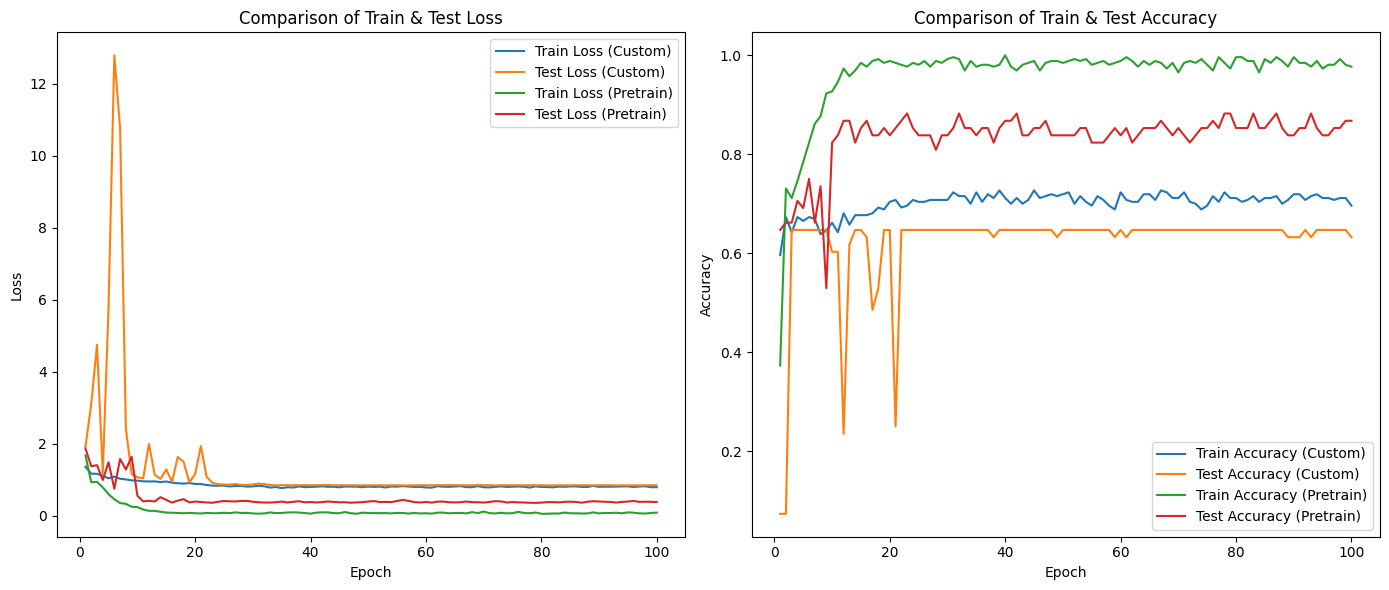

              Model  Coverge Time  Final Train Loss  Final Test Loss  \
0  Customized Model            24          0.789576         0.839995   
1  Pretrained Model            21          0.082770         0.374923   

   Final Train Accuracy  Final Test Accuracy  
0              0.696154             0.632353  
1              0.976923             0.867647  


In [24]:
import matplotlib.pyplot as plt
import pandas as pd

def get_converge_epoch(val_losses, threshold=0.01):
    diffs = [abs(val_losses[i] - val_losses[i-1]) for i in range(1, len(val_losses))]
    for i, diff in enumerate(diffs):
        if diff < threshold:
            return i + 1
    return len(val_losses)

converge = get_converge_epoch(test_loss_list)
pretrained_converge = get_converge_epoch(test_loss_list_pre)

summary_df = pd.DataFrame({
    "Model": ["Customized Model", "Pretrained Model"],
    "Coverge Time": [converge, pretrained_converge],
    "Final Train Loss": [train_loss_list[-1], train_loss_list_pre[-1]],
    "Final Test Loss": [test_loss_list[-1], test_loss_list_pre[-1]],
    "Final Train Accuracy": [train_acc_list[-1], train_acc_list_pre[-1]],
    "Final Test Accuracy": [test_acc_list[-1], test_acc_list_pre[-1]],
})

epochs = list(range(1, n_epochs+1))
plt.figure(figsize=(14, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label="Train Loss (Custom)")
plt.plot(epochs, test_loss_list, label="Test Loss (Custom)")
plt.plot(epochs, train_loss_list_pre, label="Train Loss (Pretrain)")
plt.plot(epochs, test_loss_list_pre, label="Test Loss (Pretrain)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Comparison of Train & Test Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_list, label="Train Accuracy (Custom)")
plt.plot(epochs, test_acc_list, label="Test Accuracy (Custom)")
plt.plot(epochs, train_acc_list_pre, label="Train Accuracy (Pretrain)")
plt.plot(epochs, test_acc_list_pre, label="Test Accuracy (Pretrain)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Comparison of Train & Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Comparison Table
print(summary_df)

(4) 比較不同預訓練模型的表現

In [25]:
import timm

efficientnet_model = timm.create_model("efficientnet_b0", pretrained=True)
num_classes = 6
efficientnet_model.classifier = nn.Linear(efficientnet_model.classifier.in_features, num_classes)

efficientnet_optimizer = optim.Adam(
    efficientnet_model.parameters(),
    lr=lr,
    weight_decay=5e-4
)

loss_fn = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(efficientnet_optimizer, patience=2)

train_loss_list_eff = []
test_loss_list_eff = []
train_acc_list_eff = []
test_acc_list_eff = []

for epoch in range(1, n_epochs+1):
    training_loss, training_accuracy = train(efficientnet_model, train_loader, device, efficientnet_optimizer, loss_fn, epoch)
    test_loss, test_accuracy = evaluate(efficientnet_model, test_loader, device, loss_fn, epoch)

    train_loss_list_eff.append(training_loss)
    test_loss_list_eff.append(test_loss)
    train_acc_list_eff.append(training_accuracy)
    test_acc_list_eff.append(test_accuracy)

    scheduler.step(test_loss)

    print(f"Epoch {epoch}/{n_epochs}: training accuracy: {training_accuracy}, test accuracy: {test_accuracy}")

Testing: 100%|██████████| 3/3 [00:12<00:00,  4.17s/it, epoch=1, loss=1.2719, acc=64.71%]


Test: Loss: 1.2719 | Accuracy: 0.6471 (88/136)
Epoch 1/100: training accuracy: 0.5961538461538461, test accuracy: 0.6470588235294118


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.42s/it, epoch=2, loss=1.1128, acc=66.18%]


Test: Loss: 1.1128 | Accuracy: 0.6618 (90/136)
Epoch 2/100: training accuracy: 0.7153846153846154, test accuracy: 0.6617647058823529


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.11s/it, epoch=3, loss=1.1497, acc=67.65%]


Test: Loss: 1.1497 | Accuracy: 0.6765 (92/136)
Epoch 3/100: training accuracy: 0.7730769230769231, test accuracy: 0.6764705882352942


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.99s/it, epoch=4, loss=1.3847, acc=66.18%]


Test: Loss: 1.3847 | Accuracy: 0.6618 (90/136)
Epoch 4/100: training accuracy: 0.7846153846153846, test accuracy: 0.6617647058823529


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it, epoch=5, loss=1.0157, acc=69.12%]


Test: Loss: 1.0157 | Accuracy: 0.6912 (94/136)
Epoch 5/100: training accuracy: 0.8192307692307692, test accuracy: 0.6911764705882353


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it, epoch=6, loss=0.8656, acc=72.06%]


Test: Loss: 0.8656 | Accuracy: 0.7206 (98/136)
Epoch 6/100: training accuracy: 0.8576923076923076, test accuracy: 0.7205882352941176


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.46s/it, epoch=7, loss=0.5506, acc=76.47%]


Test: Loss: 0.5506 | Accuracy: 0.7647 (104/136)
Epoch 7/100: training accuracy: 0.9, test accuracy: 0.7647058823529411


Testing: 100%|██████████| 3/3 [00:11<00:00,  3.68s/it, epoch=8, loss=0.5658, acc=83.82%]


Test: Loss: 0.5658 | Accuracy: 0.8382 (114/136)
Epoch 8/100: training accuracy: 0.9384615384615385, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.22s/it, epoch=9, loss=0.6105, acc=82.35%]


Test: Loss: 0.6105 | Accuracy: 0.8235 (112/136)
Epoch 9/100: training accuracy: 0.9230769230769231, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.08s/it, epoch=10, loss=0.5917, acc=76.47%]


Test: Loss: 0.5917 | Accuracy: 0.7647 (104/136)
Epoch 10/100: training accuracy: 0.9423076923076923, test accuracy: 0.7647058823529411


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.94s/it, epoch=11, loss=0.5679, acc=82.35%]


Test: Loss: 0.5679 | Accuracy: 0.8235 (112/136)
Epoch 11/100: training accuracy: 0.9615384615384616, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.95s/it, epoch=12, loss=0.5711, acc=83.82%]


Test: Loss: 0.5711 | Accuracy: 0.8382 (114/136)
Epoch 12/100: training accuracy: 0.9846153846153847, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it, epoch=13, loss=0.5323, acc=82.35%]


Test: Loss: 0.5323 | Accuracy: 0.8235 (112/136)
Epoch 13/100: training accuracy: 0.9884615384615385, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.49s/it, epoch=14, loss=0.5568, acc=83.82%]


Test: Loss: 0.5568 | Accuracy: 0.8382 (114/136)
Epoch 14/100: training accuracy: 0.9769230769230769, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:11<00:00,  3.92s/it, epoch=15, loss=0.4902, acc=79.41%]


Test: Loss: 0.4902 | Accuracy: 0.7941 (108/136)
Epoch 15/100: training accuracy: 0.9846153846153847, test accuracy: 0.7941176470588235


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.34s/it, epoch=16, loss=0.4711, acc=79.41%]


Test: Loss: 0.4711 | Accuracy: 0.7941 (108/136)
Epoch 16/100: training accuracy: 0.9961538461538462, test accuracy: 0.7941176470588235


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.08s/it, epoch=17, loss=0.4839, acc=82.35%]


Test: Loss: 0.4839 | Accuracy: 0.8235 (112/136)
Epoch 17/100: training accuracy: 0.9769230769230769, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.95s/it, epoch=18, loss=0.4754, acc=80.88%]


Test: Loss: 0.4754 | Accuracy: 0.8088 (110/136)
Epoch 18/100: training accuracy: 0.9961538461538462, test accuracy: 0.8088235294117647


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it, epoch=19, loss=0.5084, acc=85.29%]


Test: Loss: 0.5084 | Accuracy: 0.8529 (116/136)
Epoch 19/100: training accuracy: 0.9923076923076923, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.93s/it, epoch=20, loss=0.5427, acc=83.82%]


Test: Loss: 0.5427 | Accuracy: 0.8382 (114/136)
Epoch 20/100: training accuracy: 0.9807692307692307, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it, epoch=21, loss=0.5460, acc=82.35%]


Test: Loss: 0.5460 | Accuracy: 0.8235 (112/136)
Epoch 21/100: training accuracy: 0.9769230769230769, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:11<00:00,  3.94s/it, epoch=22, loss=0.5405, acc=82.35%]


Test: Loss: 0.5405 | Accuracy: 0.8235 (112/136)
Epoch 22/100: training accuracy: 0.9961538461538462, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.37s/it, epoch=23, loss=0.4980, acc=82.35%]


Test: Loss: 0.4980 | Accuracy: 0.8235 (112/136)
Epoch 23/100: training accuracy: 0.9884615384615385, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.07s/it, epoch=24, loss=0.4971, acc=82.35%]


Test: Loss: 0.4971 | Accuracy: 0.8235 (112/136)
Epoch 24/100: training accuracy: 0.9923076923076923, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.95s/it, epoch=25, loss=0.5361, acc=83.82%]


Test: Loss: 0.5361 | Accuracy: 0.8382 (114/136)
Epoch 25/100: training accuracy: 0.9846153846153847, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it, epoch=26, loss=0.5004, acc=83.82%]


Test: Loss: 0.5004 | Accuracy: 0.8382 (114/136)
Epoch 26/100: training accuracy: 0.9961538461538462, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.97s/it, epoch=27, loss=0.5096, acc=83.82%]


Test: Loss: 0.5096 | Accuracy: 0.8382 (114/136)
Epoch 27/100: training accuracy: 0.9846153846153847, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.94s/it, epoch=28, loss=0.4950, acc=83.82%]


Test: Loss: 0.4950 | Accuracy: 0.8382 (114/136)
Epoch 28/100: training accuracy: 0.9846153846153847, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it, epoch=29, loss=0.5348, acc=82.35%]


Test: Loss: 0.5348 | Accuracy: 0.8235 (112/136)
Epoch 29/100: training accuracy: 0.9884615384615385, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:11<00:00,  3.72s/it, epoch=30, loss=0.5267, acc=83.82%]


Test: Loss: 0.5267 | Accuracy: 0.8382 (114/136)
Epoch 30/100: training accuracy: 0.9884615384615385, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.22s/it, epoch=31, loss=0.5283, acc=82.35%]


Test: Loss: 0.5283 | Accuracy: 0.8235 (112/136)
Epoch 31/100: training accuracy: 1.0, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.06s/it, epoch=32, loss=0.5057, acc=83.82%]


Test: Loss: 0.5057 | Accuracy: 0.8382 (114/136)
Epoch 32/100: training accuracy: 0.9923076923076923, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.95s/it, epoch=33, loss=0.5295, acc=83.82%]


Test: Loss: 0.5295 | Accuracy: 0.8382 (114/136)
Epoch 33/100: training accuracy: 1.0, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it, epoch=34, loss=0.4946, acc=82.35%]


Test: Loss: 0.4946 | Accuracy: 0.8235 (112/136)
Epoch 34/100: training accuracy: 0.9923076923076923, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.94s/it, epoch=35, loss=0.5533, acc=83.82%]


Test: Loss: 0.5533 | Accuracy: 0.8382 (114/136)
Epoch 35/100: training accuracy: 0.9923076923076923, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.97s/it, epoch=36, loss=0.5255, acc=83.82%]


Test: Loss: 0.5255 | Accuracy: 0.8382 (114/136)
Epoch 36/100: training accuracy: 0.9961538461538462, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:13<00:00,  4.48s/it, epoch=37, loss=0.4908, acc=85.29%]


Test: Loss: 0.4908 | Accuracy: 0.8529 (116/136)
Epoch 37/100: training accuracy: 0.9769230769230769, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.44s/it, epoch=38, loss=0.4747, acc=85.29%]


Test: Loss: 0.4747 | Accuracy: 0.8529 (116/136)
Epoch 38/100: training accuracy: 0.9884615384615385, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.19s/it, epoch=39, loss=0.4907, acc=83.82%]


Test: Loss: 0.4907 | Accuracy: 0.8382 (114/136)
Epoch 39/100: training accuracy: 0.9923076923076923, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.98s/it, epoch=40, loss=0.5008, acc=85.29%]


Test: Loss: 0.5008 | Accuracy: 0.8529 (116/136)
Epoch 40/100: training accuracy: 0.9884615384615385, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it, epoch=41, loss=0.5434, acc=83.82%]


Test: Loss: 0.5434 | Accuracy: 0.8382 (114/136)
Epoch 41/100: training accuracy: 0.9807692307692307, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.94s/it, epoch=42, loss=0.4842, acc=79.41%]


Test: Loss: 0.4842 | Accuracy: 0.7941 (108/136)
Epoch 42/100: training accuracy: 0.9961538461538462, test accuracy: 0.7941176470588235


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.95s/it, epoch=43, loss=0.5259, acc=82.35%]


Test: Loss: 0.5259 | Accuracy: 0.8235 (112/136)
Epoch 43/100: training accuracy: 0.9846153846153847, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it, epoch=44, loss=0.5141, acc=83.82%]


Test: Loss: 0.5141 | Accuracy: 0.8382 (114/136)
Epoch 44/100: training accuracy: 0.9769230769230769, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.49s/it, epoch=45, loss=0.4954, acc=82.35%]


Test: Loss: 0.4954 | Accuracy: 0.8235 (112/136)
Epoch 45/100: training accuracy: 0.9961538461538462, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.23s/it, epoch=46, loss=0.5054, acc=85.29%]


Test: Loss: 0.5054 | Accuracy: 0.8529 (116/136)
Epoch 46/100: training accuracy: 0.9961538461538462, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.04s/it, epoch=47, loss=0.4877, acc=83.82%]


Test: Loss: 0.4877 | Accuracy: 0.8382 (114/136)
Epoch 47/100: training accuracy: 0.9923076923076923, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it, epoch=48, loss=0.5306, acc=82.35%]


Test: Loss: 0.5306 | Accuracy: 0.8235 (112/136)
Epoch 48/100: training accuracy: 0.9961538461538462, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it, epoch=49, loss=0.5465, acc=83.82%]


Test: Loss: 0.5465 | Accuracy: 0.8382 (114/136)
Epoch 49/100: training accuracy: 0.9884615384615385, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.93s/it, epoch=50, loss=0.5698, acc=85.29%]


Test: Loss: 0.5698 | Accuracy: 0.8529 (116/136)
Epoch 50/100: training accuracy: 0.9923076923076923, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.94s/it, epoch=51, loss=0.6067, acc=82.35%]


Test: Loss: 0.6067 | Accuracy: 0.8235 (112/136)
Epoch 51/100: training accuracy: 0.9846153846153847, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:11<00:00,  3.78s/it, epoch=52, loss=0.5203, acc=83.82%]


Test: Loss: 0.5203 | Accuracy: 0.8382 (114/136)
Epoch 52/100: training accuracy: 0.9923076923076923, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.33s/it, epoch=53, loss=0.5133, acc=83.82%]


Test: Loss: 0.5133 | Accuracy: 0.8382 (114/136)
Epoch 53/100: training accuracy: 0.9807692307692307, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.10s/it, epoch=54, loss=0.5517, acc=80.88%]


Test: Loss: 0.5517 | Accuracy: 0.8088 (110/136)
Epoch 54/100: training accuracy: 0.9884615384615385, test accuracy: 0.8088235294117647


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.93s/it, epoch=55, loss=0.5415, acc=83.82%]


Test: Loss: 0.5415 | Accuracy: 0.8382 (114/136)
Epoch 55/100: training accuracy: 0.9884615384615385, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it, epoch=56, loss=0.5325, acc=83.82%]


Test: Loss: 0.5325 | Accuracy: 0.8382 (114/136)
Epoch 56/100: training accuracy: 0.9923076923076923, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.95s/it, epoch=57, loss=0.5180, acc=85.29%]


Test: Loss: 0.5180 | Accuracy: 0.8529 (116/136)
Epoch 57/100: training accuracy: 0.9884615384615385, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.94s/it, epoch=58, loss=0.5447, acc=83.82%]


Test: Loss: 0.5447 | Accuracy: 0.8382 (114/136)
Epoch 58/100: training accuracy: 0.9884615384615385, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:11<00:00,  4.00s/it, epoch=59, loss=0.5366, acc=83.82%]


Test: Loss: 0.5366 | Accuracy: 0.8382 (114/136)
Epoch 59/100: training accuracy: 0.9961538461538462, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.37s/it, epoch=60, loss=0.5475, acc=83.82%]


Test: Loss: 0.5475 | Accuracy: 0.8382 (114/136)
Epoch 60/100: training accuracy: 0.9846153846153847, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.24s/it, epoch=61, loss=0.5547, acc=83.82%]


Test: Loss: 0.5547 | Accuracy: 0.8382 (114/136)
Epoch 61/100: training accuracy: 0.9884615384615385, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.45s/it, epoch=62, loss=0.5114, acc=82.35%]


Test: Loss: 0.5114 | Accuracy: 0.8235 (112/136)
Epoch 62/100: training accuracy: 0.9923076923076923, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.96s/it, epoch=63, loss=0.5921, acc=80.88%]


Test: Loss: 0.5921 | Accuracy: 0.8088 (110/136)
Epoch 63/100: training accuracy: 0.9884615384615385, test accuracy: 0.8088235294117647


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.96s/it, epoch=64, loss=0.6466, acc=79.41%]


Test: Loss: 0.6466 | Accuracy: 0.7941 (108/136)
Epoch 64/100: training accuracy: 0.9769230769230769, test accuracy: 0.7941176470588235


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.94s/it, epoch=65, loss=0.5620, acc=83.82%]


Test: Loss: 0.5620 | Accuracy: 0.8382 (114/136)
Epoch 65/100: training accuracy: 0.9923076923076923, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:11<00:00,  3.77s/it, epoch=66, loss=0.5316, acc=85.29%]


Test: Loss: 0.5316 | Accuracy: 0.8529 (116/136)
Epoch 66/100: training accuracy: 0.9769230769230769, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.37s/it, epoch=67, loss=0.5816, acc=83.82%]


Test: Loss: 0.5816 | Accuracy: 0.8382 (114/136)
Epoch 67/100: training accuracy: 0.9923076923076923, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.05s/it, epoch=68, loss=0.5424, acc=85.29%]


Test: Loss: 0.5424 | Accuracy: 0.8529 (116/136)
Epoch 68/100: training accuracy: 0.9807692307692307, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.49s/it, epoch=69, loss=0.5148, acc=83.82%]


Test: Loss: 0.5148 | Accuracy: 0.8382 (114/136)
Epoch 69/100: training accuracy: 0.9923076923076923, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.93s/it, epoch=70, loss=0.5117, acc=83.82%]


Test: Loss: 0.5117 | Accuracy: 0.8382 (114/136)
Epoch 70/100: training accuracy: 0.9961538461538462, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it, epoch=71, loss=0.5202, acc=85.29%]


Test: Loss: 0.5202 | Accuracy: 0.8529 (116/136)
Epoch 71/100: training accuracy: 0.9923076923076923, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.94s/it, epoch=72, loss=0.5006, acc=85.29%]


Test: Loss: 0.5006 | Accuracy: 0.8529 (116/136)
Epoch 72/100: training accuracy: 1.0, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.19s/it, epoch=73, loss=0.5468, acc=83.82%]


Test: Loss: 0.5468 | Accuracy: 0.8382 (114/136)
Epoch 73/100: training accuracy: 0.9923076923076923, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.46s/it, epoch=74, loss=0.5480, acc=83.82%]


Test: Loss: 0.5480 | Accuracy: 0.8382 (114/136)
Epoch 74/100: training accuracy: 0.9884615384615385, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.24s/it, epoch=75, loss=0.5505, acc=82.35%]


Test: Loss: 0.5505 | Accuracy: 0.8235 (112/136)
Epoch 75/100: training accuracy: 0.9961538461538462, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.42s/it, epoch=76, loss=0.5670, acc=83.82%]


Test: Loss: 0.5670 | Accuracy: 0.8382 (114/136)
Epoch 76/100: training accuracy: 0.9884615384615385, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.98s/it, epoch=77, loss=0.5182, acc=83.82%]


Test: Loss: 0.5182 | Accuracy: 0.8382 (114/136)
Epoch 77/100: training accuracy: 0.9846153846153847, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.97s/it, epoch=78, loss=0.5174, acc=83.82%]


Test: Loss: 0.5174 | Accuracy: 0.8382 (114/136)
Epoch 78/100: training accuracy: 1.0, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.89s/it, epoch=79, loss=0.5480, acc=83.82%]


Test: Loss: 0.5480 | Accuracy: 0.8382 (114/136)
Epoch 79/100: training accuracy: 0.9846153846153847, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:11<00:00,  4.00s/it, epoch=80, loss=0.5114, acc=83.82%]


Test: Loss: 0.5114 | Accuracy: 0.8382 (114/136)
Epoch 80/100: training accuracy: 0.9961538461538462, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.35s/it, epoch=81, loss=0.5557, acc=83.82%]


Test: Loss: 0.5557 | Accuracy: 0.8382 (114/136)
Epoch 81/100: training accuracy: 0.9923076923076923, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.05s/it, epoch=82, loss=0.5571, acc=80.88%]


Test: Loss: 0.5571 | Accuracy: 0.8088 (110/136)
Epoch 82/100: training accuracy: 0.9807692307692307, test accuracy: 0.8088235294117647


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.98s/it, epoch=83, loss=0.5543, acc=83.82%]


Test: Loss: 0.5543 | Accuracy: 0.8382 (114/136)
Epoch 83/100: training accuracy: 0.9884615384615385, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.07s/it, epoch=84, loss=0.5421, acc=83.82%]


Test: Loss: 0.5421 | Accuracy: 0.8382 (114/136)
Epoch 84/100: training accuracy: 0.9961538461538462, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.37s/it, epoch=85, loss=0.5446, acc=83.82%]


Test: Loss: 0.5446 | Accuracy: 0.8382 (114/136)
Epoch 85/100: training accuracy: 0.9769230769230769, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it, epoch=86, loss=0.5357, acc=80.88%]


Test: Loss: 0.5357 | Accuracy: 0.8088 (110/136)
Epoch 86/100: training accuracy: 0.9961538461538462, test accuracy: 0.8088235294117647


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it, epoch=87, loss=0.5614, acc=82.35%]


Test: Loss: 0.5614 | Accuracy: 0.8235 (112/136)
Epoch 87/100: training accuracy: 0.9923076923076923, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:11<00:00,  3.68s/it, epoch=88, loss=0.5268, acc=83.82%]


Test: Loss: 0.5268 | Accuracy: 0.8382 (114/136)
Epoch 88/100: training accuracy: 0.9884615384615385, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.22s/it, epoch=89, loss=0.5932, acc=80.88%]


Test: Loss: 0.5932 | Accuracy: 0.8088 (110/136)
Epoch 89/100: training accuracy: 0.9807692307692307, test accuracy: 0.8088235294117647


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.06s/it, epoch=90, loss=0.5798, acc=83.82%]


Test: Loss: 0.5798 | Accuracy: 0.8382 (114/136)
Epoch 90/100: training accuracy: 0.9923076923076923, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.95s/it, epoch=91, loss=0.6480, acc=83.82%]


Test: Loss: 0.6480 | Accuracy: 0.8382 (114/136)
Epoch 91/100: training accuracy: 0.9884615384615385, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it, epoch=92, loss=0.5546, acc=85.29%]


Test: Loss: 0.5546 | Accuracy: 0.8529 (116/136)
Epoch 92/100: training accuracy: 0.9923076923076923, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it, epoch=93, loss=0.5636, acc=80.88%]


Test: Loss: 0.5636 | Accuracy: 0.8088 (110/136)
Epoch 93/100: training accuracy: 0.9807692307692307, test accuracy: 0.8088235294117647


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it, epoch=94, loss=0.5300, acc=83.82%]


Test: Loss: 0.5300 | Accuracy: 0.8382 (114/136)
Epoch 94/100: training accuracy: 0.9961538461538462, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:11<00:00,  3.88s/it, epoch=95, loss=0.5119, acc=85.29%]


Test: Loss: 0.5119 | Accuracy: 0.8529 (116/136)
Epoch 95/100: training accuracy: 0.9884615384615385, test accuracy: 0.8529411764705882


Testing: 100%|██████████| 3/3 [00:10<00:00,  3.35s/it, epoch=96, loss=0.5517, acc=82.35%]


Test: Loss: 0.5517 | Accuracy: 0.8235 (112/136)
Epoch 96/100: training accuracy: 0.9961538461538462, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:09<00:00,  3.02s/it, epoch=97, loss=0.5210, acc=82.35%]


Test: Loss: 0.5210 | Accuracy: 0.8235 (112/136)
Epoch 97/100: training accuracy: 0.9923076923076923, test accuracy: 0.8235294117647058


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.98s/it, epoch=98, loss=0.5102, acc=83.82%]


Test: Loss: 0.5102 | Accuracy: 0.8382 (114/136)
Epoch 98/100: training accuracy: 0.9846153846153847, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it, epoch=99, loss=0.5020, acc=83.82%]


Test: Loss: 0.5020 | Accuracy: 0.8382 (114/136)
Epoch 99/100: training accuracy: 0.9923076923076923, test accuracy: 0.8382352941176471


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it, epoch=100, loss=0.5538, acc=82.35%]

Test: Loss: 0.5538 | Accuracy: 0.8235 (112/136)
Epoch 100/100: training accuracy: 0.9961538461538462, test accuracy: 0.8235294117647058


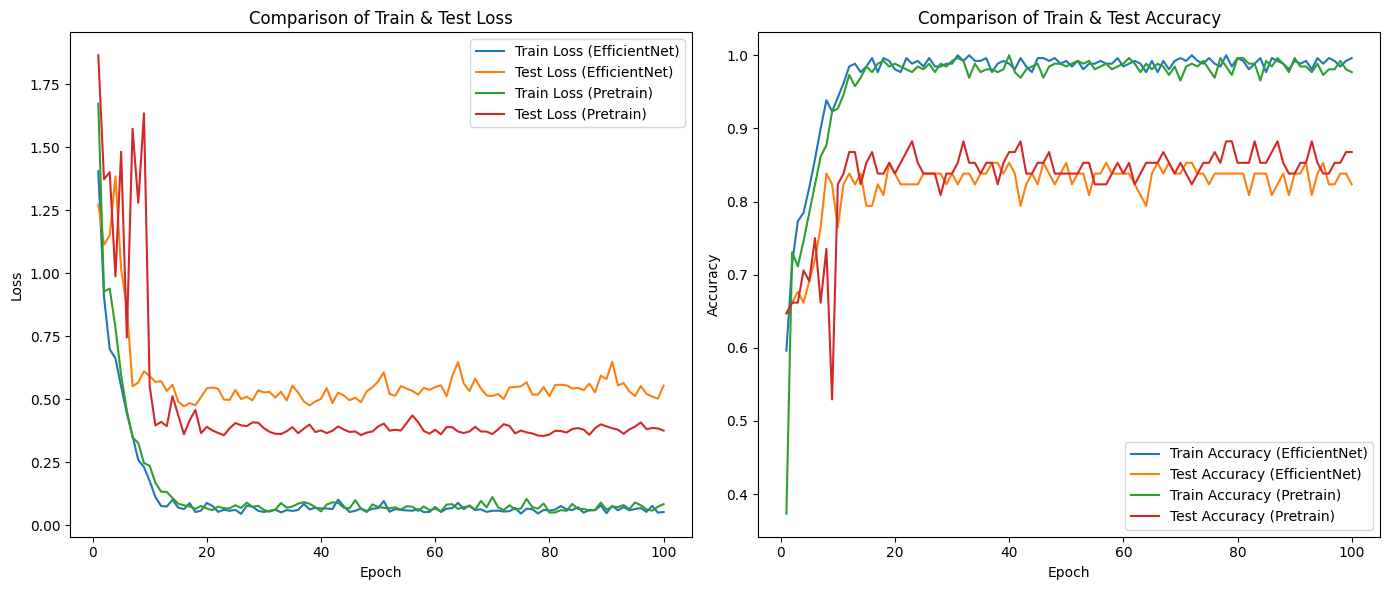

                Model  Coverge Time  Final Train Loss  Final Test Loss  \
0  EfficientNet Model            11          0.051611         0.553800   
1    Pretrained Model            21          0.082770         0.374923   

   Final Train Accuracy  Final Test Accuracy  
0              0.996154             0.823529  
1              0.976923             0.867647  


In [26]:
def get_converge_epoch(val_losses, threshold=0.01):
    diffs = [abs(val_losses[i] - val_losses[i-1]) for i in range(1, len(val_losses))]
    for i, diff in enumerate(diffs):
        if diff < threshold:
            return i + 1
    return len(val_losses)

eff_converge = get_converge_epoch(test_loss_list_eff)

summary_df_eff = pd.DataFrame({
    "Model": ["EfficientNet Model", "Pretrained Model"],
    "Coverge Time": [eff_converge, pretrained_converge],
    "Final Train Loss": [train_loss_list_eff[-1], train_loss_list_pre[-1]],
    "Final Test Loss": [test_loss_list_eff[-1], test_loss_list_pre[-1]],
    "Final Train Accuracy": [train_acc_list_eff[-1], train_acc_list_pre[-1]],
    "Final Test Accuracy": [test_acc_list_eff[-1], test_acc_list_pre[-1]],
})

epochs = list(range(1, n_epochs+1))
plt.figure(figsize=(14, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list_eff, label="Train Loss (EfficientNet)")
plt.plot(epochs, test_loss_list_eff, label="Test Loss (EfficientNet)")
plt.plot(epochs, train_loss_list_pre, label="Train Loss (Pretrain)")
plt.plot(epochs, test_loss_list_pre, label="Test Loss (Pretrain)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Comparison of Train & Test Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_list_eff, label="Train Accuracy (EfficientNet)")
plt.plot(epochs, test_acc_list_eff, label="Test Accuracy (EfficientNet)")
plt.plot(epochs, train_acc_list_pre, label="Train Accuracy (Pretrain)")
plt.plot(epochs, test_acc_list_pre, label="Test Accuracy (Pretrain)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Comparison of Train & Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Comparison Table
print(summary_df_eff)